# Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

In [2]:
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels)], axis=1)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['preds'].sum()
        self.performance_measures['Neg'] = self.performance_df.shape[0] - self.performance_df['preds'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])

### Read raw training data

In [3]:
amazon = pd.read_csv('/Users/Aaron_hill/Dropbox/data/week06/raw_data_train.csv')
# amazon = pd.read_csv('/Users/aaron/Dropbox/data/week06/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      188941         73792   73793  B000HDOPZG   AWIW6ZQ47MNJH   
1      220592        200455  200456  B008O2EHNC  A21S0K5PU4YO9L   
2       20265        529969  529970  B000O2APH2  A3621NVN1FSGMO   
3      265113        197131  197132  B000FNH1C2  A2SHXT0YBG49TO   
4       14678         57724   57725  B000EVOSE4  A1JFIH71386GBV   

                          ProfileName  HelpfulnessNumerator  \
0                          S F Norman                     1   
1                      third time mom                    17   
2  Norman J. Pieniazek "Orchid lover"                     1   
3                            K. Lantz                     1   
4             Jennifer Anderson "Jen"                     0   

   HelpfulnessDenominator  Score        Time  \
0                       1      5  1333929600   
1                      17      5  1338854400   
2                       1      5  1245888000   
3                       1 

### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

(364000, 131072)


In [6]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl', 'transformer.pkl_01.npy', 'transformer.pkl_02.npy']

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [10]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        519
1      5       1395
2      5        821
3      5         82
4      5        169
5      5        159
6      4        297
7      2        628
8      1        607
9      3       3188
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [11]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


### Create `X`, scaled matrix of features

In [12]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl', 'sc.pkl_01.npy', 'sc.pkl_02.npy', 'sc.pkl_03.npy']

### create `y`, vector of Labels

In [13]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### fit models

In [14]:
# MODEL: SVM, linear
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'FP': 13118, 'Accuracy': 0.92392307692307696, 'Neg': 338836, 'FN': 14574, 'Pos': 25164, 'TP': 12046, 'TN': 324262}


In [15]:
# MODEL: logistic regression
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'FP': 13269, 'Accuracy': 0.92777747252747256, 'Neg': 337131, 'FN': 13020, 'Pos': 26869, 'TP': 13600, 'TN': 324111}


In [16]:
# MODEL: Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'FP': 41661, 'Accuracy': 0.85943956043956049, 'Neg': 305222, 'FN': 9503, 'Pos': 58778, 'TP': 17117, 'TN': 295719}


In [17]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'FP': 636, 'Accuracy': 0.94698351648351653, 'Neg': 355406, 'FN': 18662, 'Pos': 8594, 'TP': 7958, 'TN': 336744}


In [18]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'FP': 14113, 'Accuracy': 0.92207692307692313, 'Neg': 337518, 'FN': 14251, 'Pos': 26482, 'TP': 12369, 'TN': 323267}


### ROC plot to compare performance of various models and fits

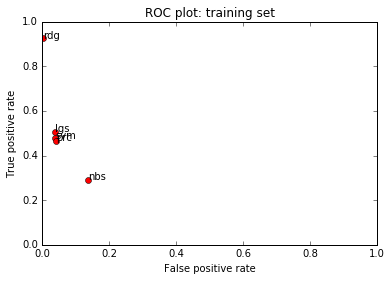

In [19]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()